In [734]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from ipywidgets import Dropdown, interactive_output
from IPython.display import display

In [735]:
# Loading the data and creating a combined dataframe
df_2022 = pd.read_csv('/content/drive/MyDrive/IPL Analysis/ipl_2022_deliveries.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/IPL Analysis/ipl_2023_deliveries.csv')
df_2024 = pd.read_csv('/content/drive/MyDrive/IPL Analysis/ipl_2024_deliveries.csv')
df_2025 = pd.read_csv('/content/drive/MyDrive/IPL Analysis/ipl_2025_deliveries.csv')
matches_df = pd.read_csv('/content/drive/MyDrive/IPL Analysis/ipl_2008_to_2025.csv')

combined_df = pd.concat([df_2022, df_2023, df_2024, df_2025], ignore_index = True)

# Preview
print(combined_df.shape)

(69597, 21)


In [736]:
# Creating the working dataframe (all the rows where over is between 16 and 20)
working_df = combined_df[(combined_df['over'] >= 16) & (combined_df['over'] <= 20)].copy()

In [737]:
# Creating a recent matches dataframe (all the matches from 2022 - 2025)
matches_df.rename(columns={'Match id': 'match_id'}, inplace=True)
matches_recent = matches_df[matches_df['match_id'] >= 202200].copy()

In [738]:
# Adding a column for 'closeness', or how close the game was (this will come in handy later when we'll assign more weight to good performances in close games)
def assign_closeness(row):
    if row['Win_Type'] == 'wickets':
        if row['Win_Margin'] <= 3:
            return 'Very Close'
        elif row['Win_Margin'] <= 5:
            return 'Close'
        else:
            return 'One-sided'

    elif row['Win_Type'] == 'runs':
        if row['Win_Margin'] <= 6:
            return 'Nailbiter'
        if row['Win_Margin'] <= 10:
            return 'Very Close'
        elif row['Win_Margin'] <= 25:
            return 'Close'
        else:
            return 'One-sided'
    else:
        return 'Unknown'

matches_recent['closeness'] = matches_recent.apply(assign_closeness, axis=1)

In [739]:
# Merging 'closeness' with the working dataframe
closeness_df = matches_recent[['match_id', 'closeness']]
working_df = working_df.merge(closeness_df, on='match_id', how='left')

In [740]:
# First 15 bowlers arranged according to their number of deliveries in the death overs
working_df['bowler'].value_counts().head(15)

,count
bowler,
Harshal Patel,446
Bhuvneshwar,398
Arshdeep Singh,384
Avesh Khan,383
Pathirana,331
T Natarajan,320
Siraj,317
Bumrah,278
Sandeep Sharma,276


In [741]:
# Filtering out no balls and wides
valid_balls = working_df[(working_df['wide'] == 0) & (working_df['noballs'] == 0)]

In [742]:
# Calculating metrics like dot balls, boundaries conceded, and wickets taken using the valid_balls df (excludes wides and no balls)
valid_metrics = valid_balls.groupby('bowler').agg(
    balls_bowled = ('over', 'count'),
    runs_off_bat = ('runs_of_bat', 'sum'),
    dot_balls = ('runs_of_bat', lambda x: (x == 0).sum()),
    boundaries_conceded = ('runs_of_bat', lambda x: ((x == 4) | (x == 6)).sum()),
    wickets_taken = ('wicket_type', lambda x: x.notnull().sum()),
)

# Calculating extras conceded using true_extras (since it includes just wides and no balls, which were excluded in valid_balls)
true_extras = working_df[
    (working_df['extras'] > 0) &
    (working_df['legbyes'] == 0) &
    (working_df['byes'] == 0)
    ]

extra_metrics = true_extras.groupby('bowler').agg(
    extras_conceded = ('extras', 'sum')

)

metrics = valid_metrics.join(extra_metrics)
metrics['extras_conceded'] = metrics['extras_conceded'].fillna(0)  # ensure it's 0, not NaN

metrics['total_runs_conceded'] = valid_metrics['runs_off_bat'] + metrics['extras_conceded']
metrics['economy_rate'] = ((metrics['total_runs_conceded']) / (metrics['balls_bowled'] / 6)).round(2)
metrics['dot_ball_percentage'] = ((metrics['dot_balls']) * 100 / (metrics['balls_bowled'])).round(2)
metrics['boundary_percentage'] = ((metrics['boundaries_conceded']) * 100 / (metrics['total_runs_conceded'])).round(2)
metrics['strike_rate'] = ((metrics['balls_bowled']) / (metrics['wickets_taken'])).round(2)

In [743]:
# Filtering the metrics dataframe to only keep bowlers who have bowled, on an average, atleast 5 death overs in a year (20 death overs in the last 4 years)
filtered_metrics = metrics[metrics['balls_bowled'] >= 120]

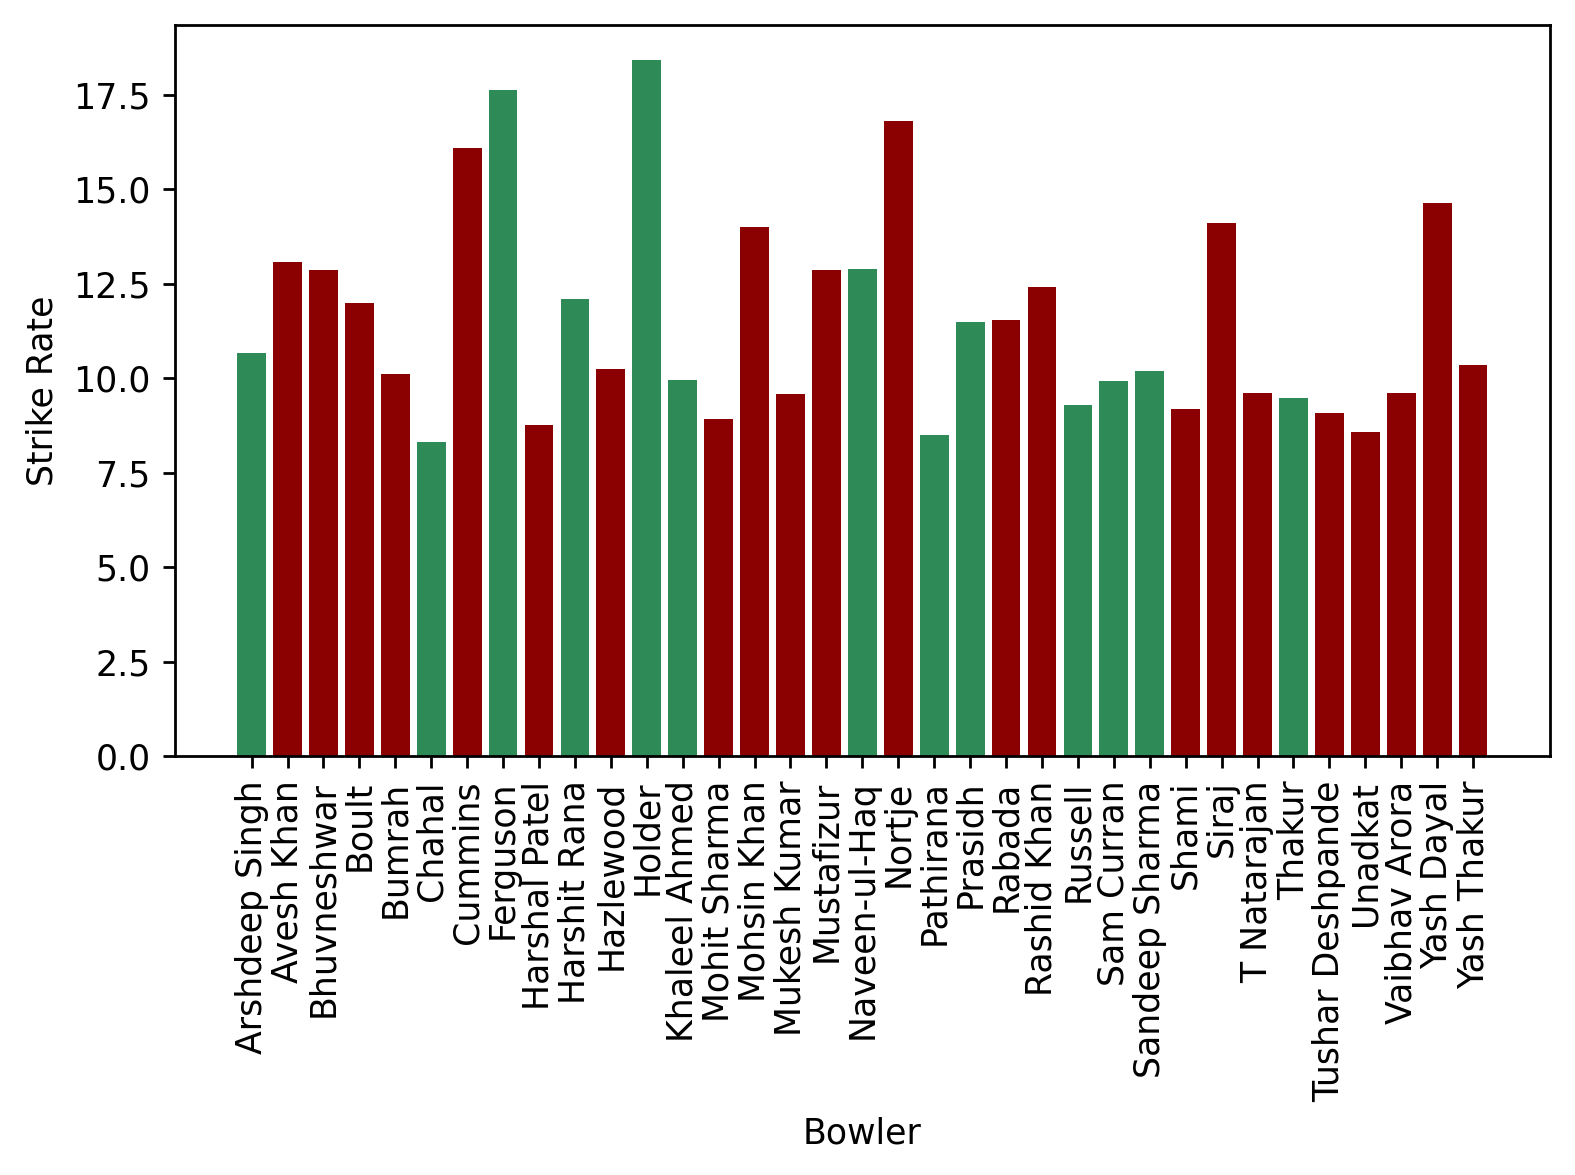

In [744]:
# Bar plot for Strike Rate
plt.figure(dpi = 250)
colors = ['seagreen' if x < 12 else 'darkred' for x in metrics['strike_rate']]

filtered_metrics.reset_index(inplace = True)
plt.bar(filtered_metrics['bowler'], filtered_metrics['strike_rate'], color = colors)
plt.xlabel('Bowler')
plt.ylabel('Strike Rate')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

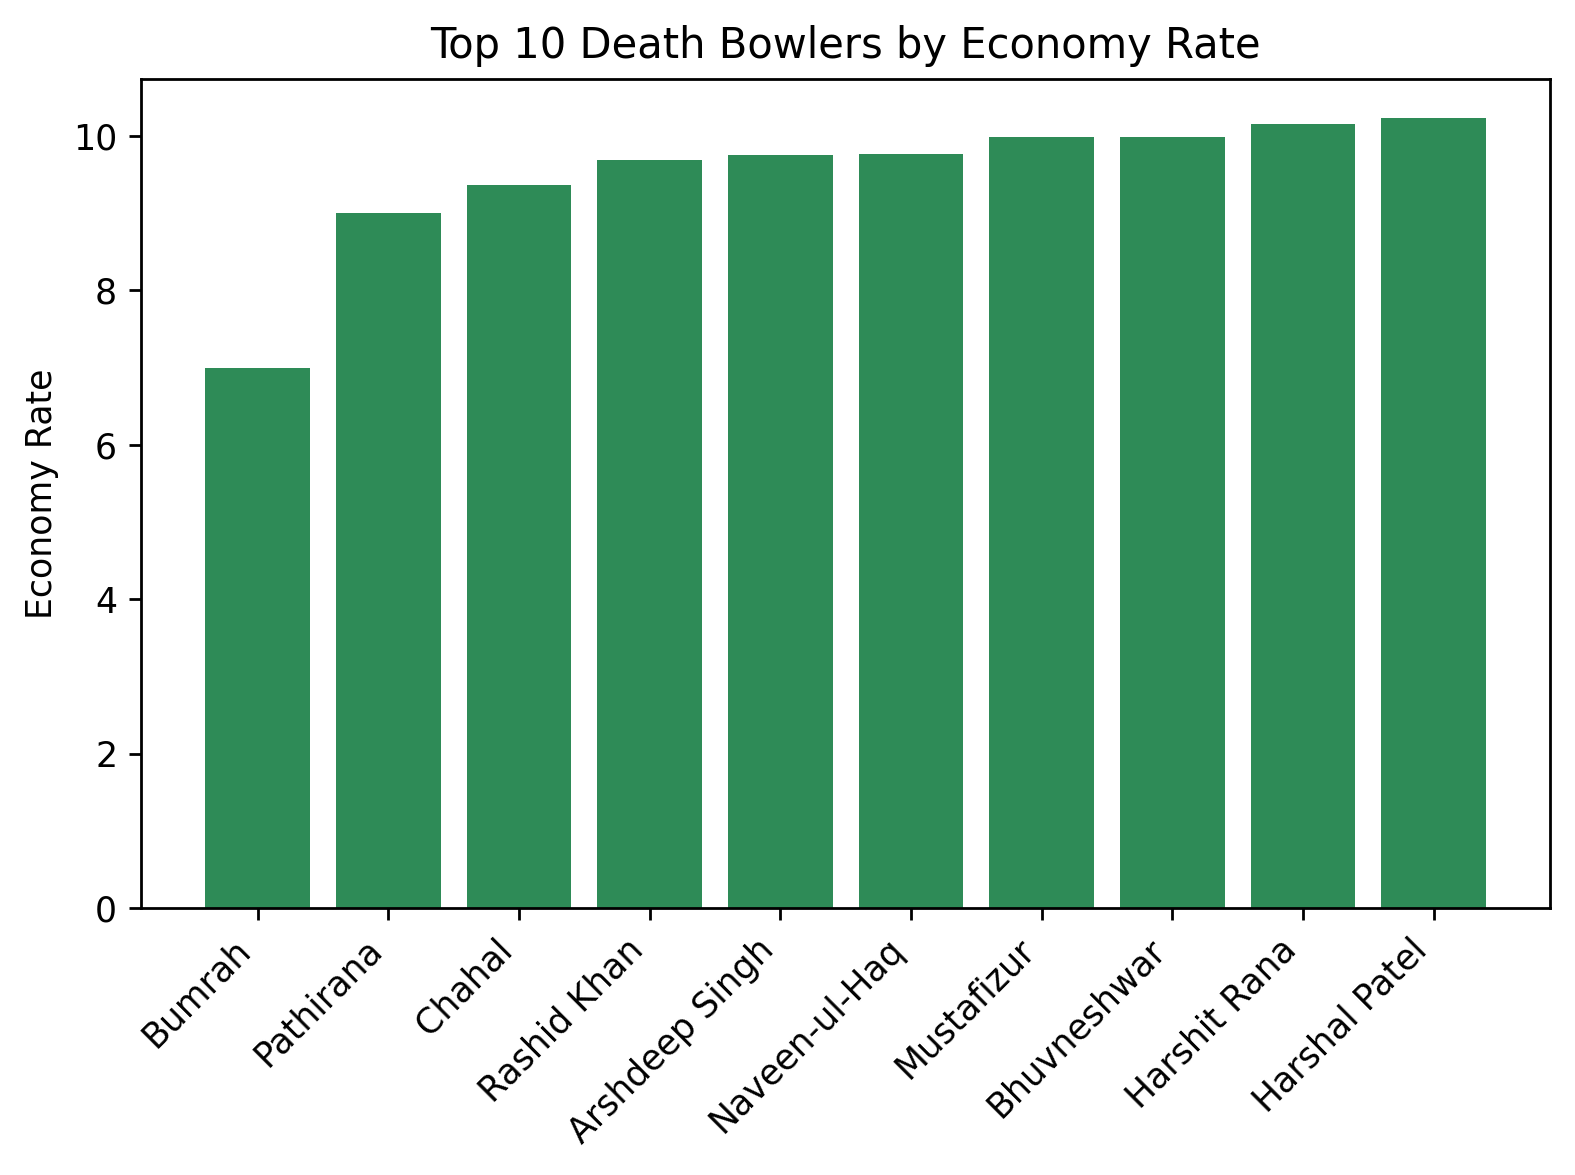

In [745]:
# Bar plot for top 10 bowlers by Economy Rate
top_economical_bowlers = filtered_metrics.sort_values(by = 'economy_rate').head(10)

plt.figure(dpi = 250)
plt.bar(top_economical_bowlers['bowler'], top_economical_bowlers['economy_rate'], color='seagreen')
plt.title('Top 10 Death Bowlers by Economy Rate'),
plt.ylabel('Economy Rate'),
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

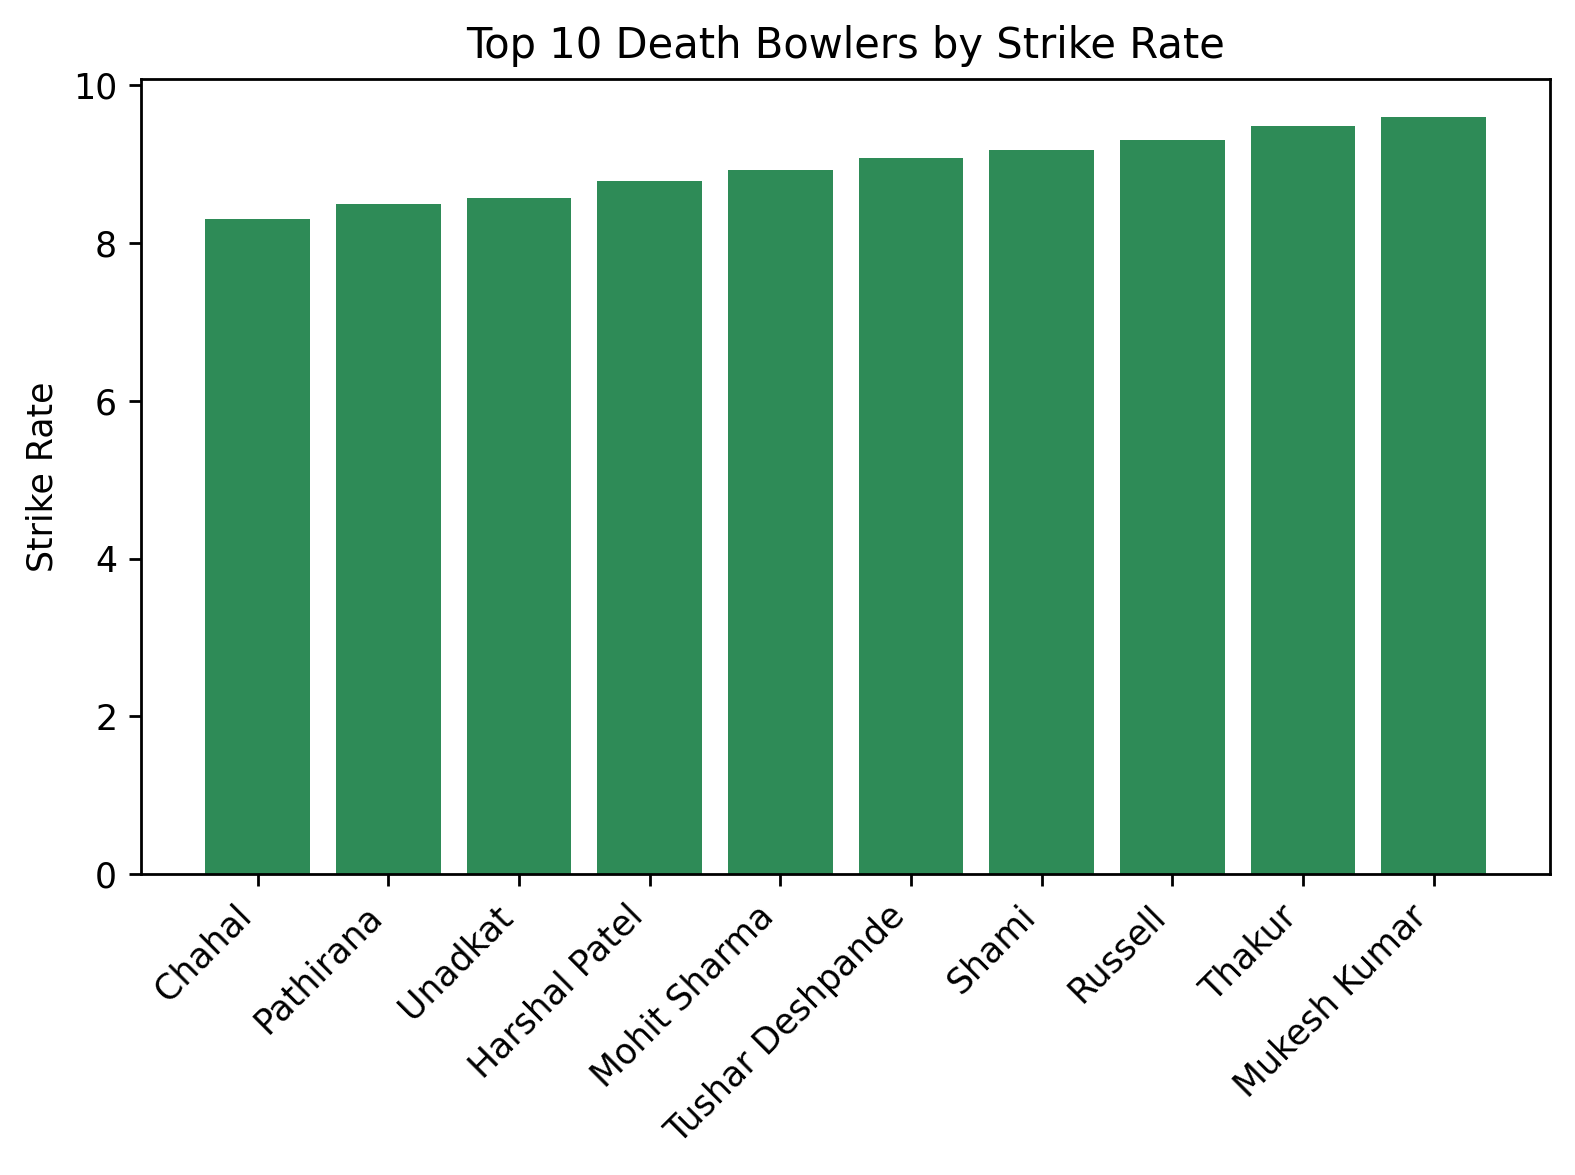

In [746]:
# Bar plot for top 10 bowlers by Strike Rate
top_sr_bowlers = filtered_metrics.sort_values(by='strike_rate', ascending = True).head(10)

plt.figure(dpi = 250)
plt.bar(top_sr_bowlers['bowler'], top_sr_bowlers['strike_rate'], color = 'seagreen')
plt.title('Top 10 Death Bowlers by Strike Rate'),
plt.ylabel('Strike Rate'),
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

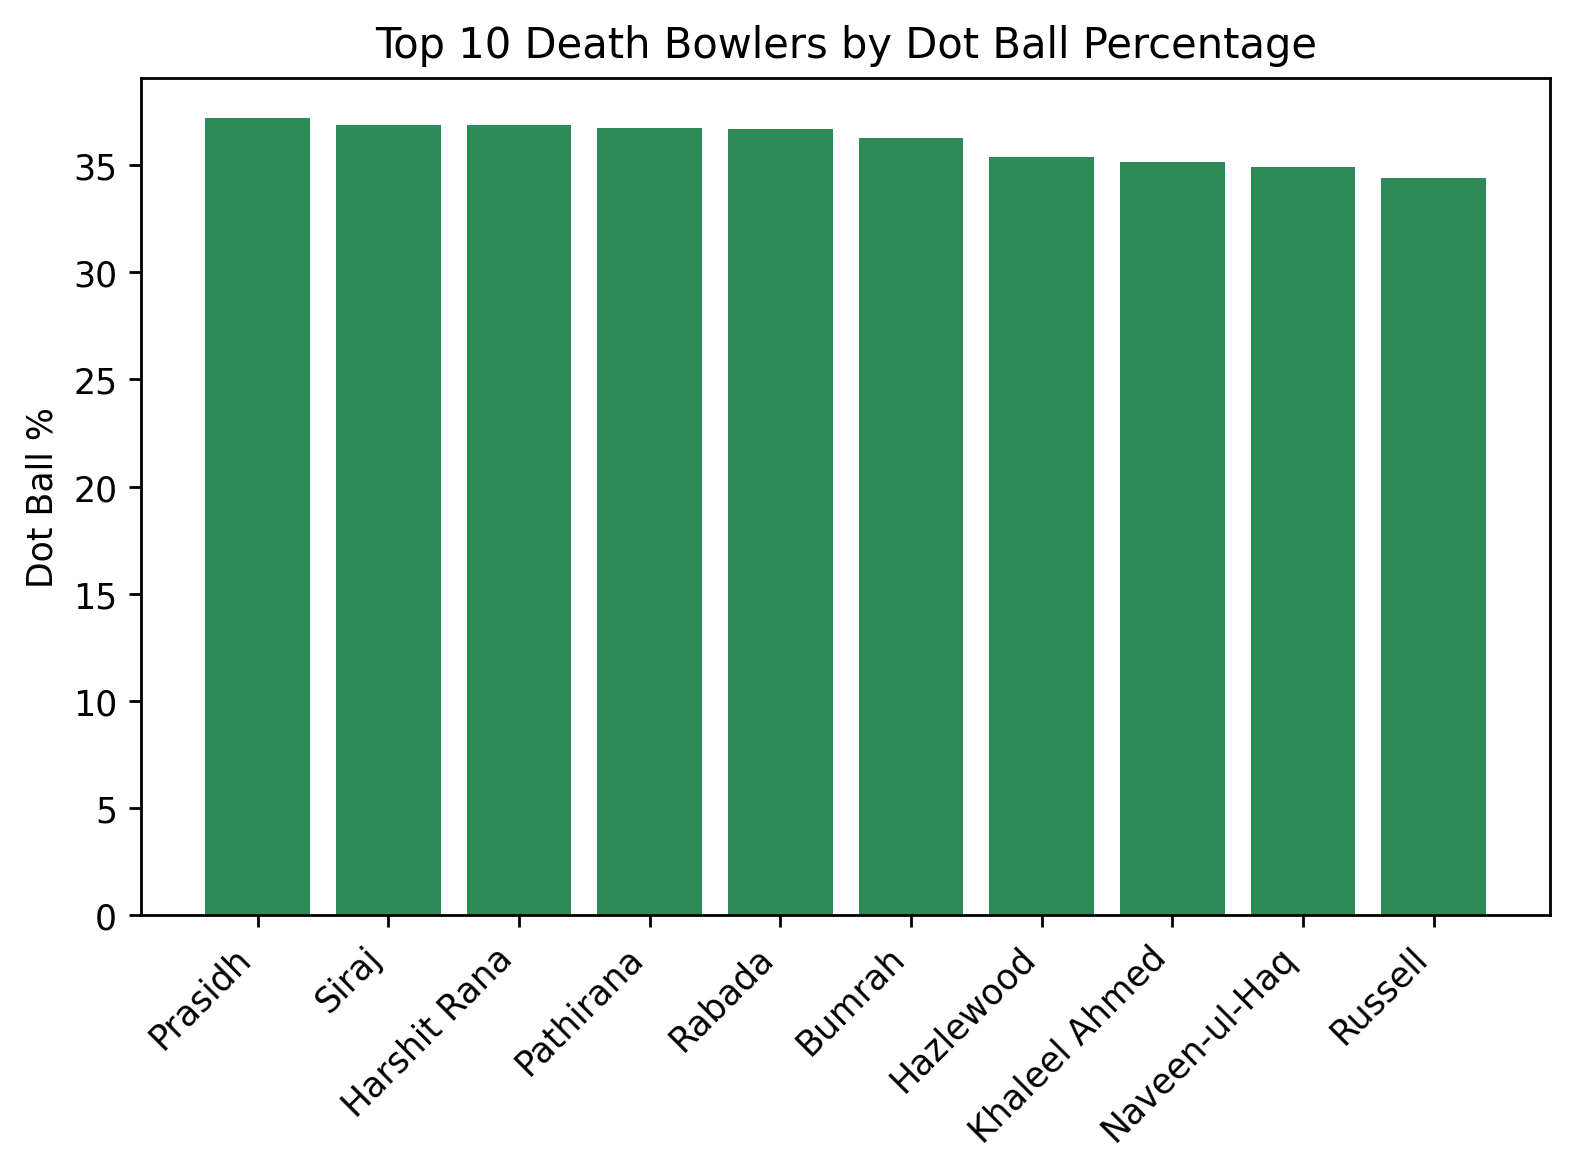

In [747]:
# Bar plot for top 10 bowlers by Dot Ball %
top_dot_bowlers = filtered_metrics.sort_values(by='dot_ball_percentage', ascending = False).head(10)

plt.figure(dpi = 250)
plt.bar(top_dot_bowlers['bowler'], top_dot_bowlers['dot_ball_percentage'], color = 'seagreen')
plt.title('Top 10 Death Bowlers by Dot Ball Percentage'),
plt.ylabel('Dot Ball %'),
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

In [748]:
# Creating a Pressure Index:
# 1. I've assigned weightage to dots/wickets/extras in death overs, those in the second innings have even more weightage, since they're naturally match-defining
# 2. The pressure score for each delivery is grouped by 'bowler' and then aggregated
# 3. Scores are then normalised on a scale of 1-100
# This gives us a much more comprehensive analysis than just comparing raw stats, it essentially tells us how well they perform when it matters

def calculate_pressure_score(row):
    score = 0

    # Over multiplier (applies in both innings, scales more in 2nd)
    over_multiplier = {
        16 : 1.0,
        17 : 1.0,
        18: 1.2,
        19: 1.4,
        20: 1.5
    }
    over_factor = over_multiplier[int(float(row['over']))]


    # Default weights
    dot_weight = 1.0
    wicket_weight = 2.5
    extra_penalty = -0.5
    boundary_penalty = -1.5

    #Adjusting weights for second innings
    if row['innings'] == 2:
        if row['closeness'] in ['Nailbiter']:
            dot_weight, wicket_weight, extra_penalty, boundary_penalty = 1.8, 4.5, -1, -2.5
        elif row['closeness'] in ['Very Close']:
            dot_weight, wicket_weight, extra_penalty, boundary_penalty = 1.5, 4.0, -0.8, -2.0
        elif row['closeness'] in ['Close']:
            dot_weight, wicket_weight, extra_penalty, boundary_penalty = 1.2, 3.0, -0.6, -1.7

# Dot ball
    if row['runs_of_bat'] == 0 and row['wicket_type'] is None:
        score += dot_weight
# Wicket
    if pd.notnull(row['wicket_type']):
        score += wicket_weight

# Extras
    if row['wide'] > 0 or row['noballs'] > 0:
        score += extra_penalty
# Boundaries
    if row['runs_of_bat'] in [4, 6]:
            score += boundary_penalty

# Final pressure score: base score × over factor
    return score * over_factor

In [749]:
# Adding a pressure score column to working_df, which assigns a score to each delivery bowled
working_df['pressure_score'] = working_df.apply(calculate_pressure_score, axis=1)

In [750]:
# Grouping working_df by bowler and summing the pressure scores for all deliveries bowled by each bowler
pressure_by_bowler = working_df.groupby('bowler')['pressure_score'].sum().reset_index()

# Merging the pressure score score column with the metrics dataframe in a new dataframe called 'contextual_metrics'
contextual_metrics = filtered_metrics.merge(pressure_by_bowler, on='bowler', how='left')

In [751]:
# Normalizing the absolute pressure scores to a scale of 1-100 using the min-max technique
min_score = contextual_metrics['pressure_score'].min()
max_score = contextual_metrics['pressure_score'].max()

contextual_metrics['normalized_pressure'] = (((contextual_metrics['pressure_score'] - min_score) / (max_score - min_score)) * 99 + 1).round(2)
working_df['normalized_pressure'] = ((working_df['pressure_score'] - min_score) / (max_score - min_score) * 100).round(2)

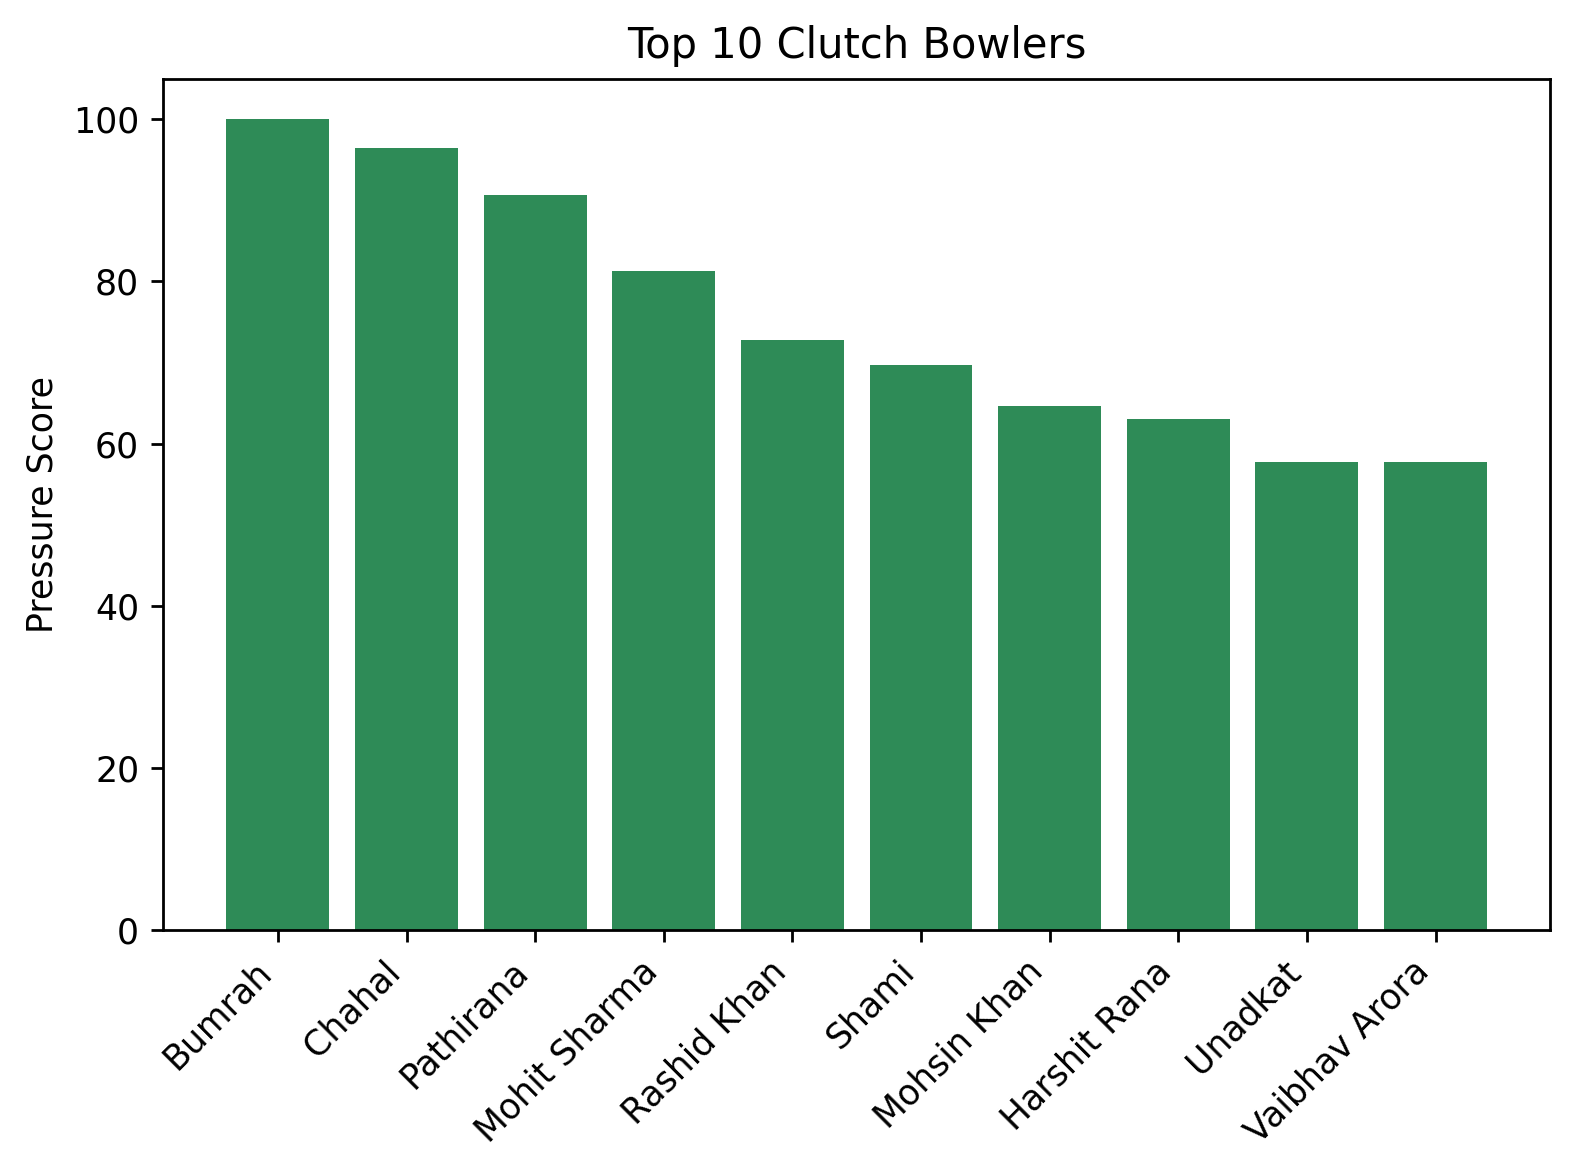

In [752]:
# Bar plot for top 10 bowlers by normalized pressure score
top_clutch_bowlers = contextual_metrics.sort_values(by='normalized_pressure', ascending = False).head(10)

plt.figure(dpi = 250)
plt.bar(top_clutch_bowlers['bowler'], top_clutch_bowlers['normalized_pressure'], color='seagreen')
plt.title('Top 10 Clutch Bowlers'),
plt.ylabel('Pressure Score'),
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

In [753]:
# Line plot for all consistent death bowlers by pressure score
sorted_contextual_metrics = contextual_metrics.sort_values(by = 'normalized_pressure', ascending=False)

# Line plot for filtered bowlers
fig = px.line(
    sorted_contextual_metrics,
    x = 'bowler',
    y = 'normalized_pressure',
    title = 'Pressure Score Across Bowlers (Min 120 Balls)',
    line_shape = 'spline',
    markers = True
)
fig.update_layout(
    xaxis_title = 'Bowler',
    yaxis_title = 'Pressure Score',
    xaxis_tickangle = 45,
    template = 'plotly_white',

)
fig.show()

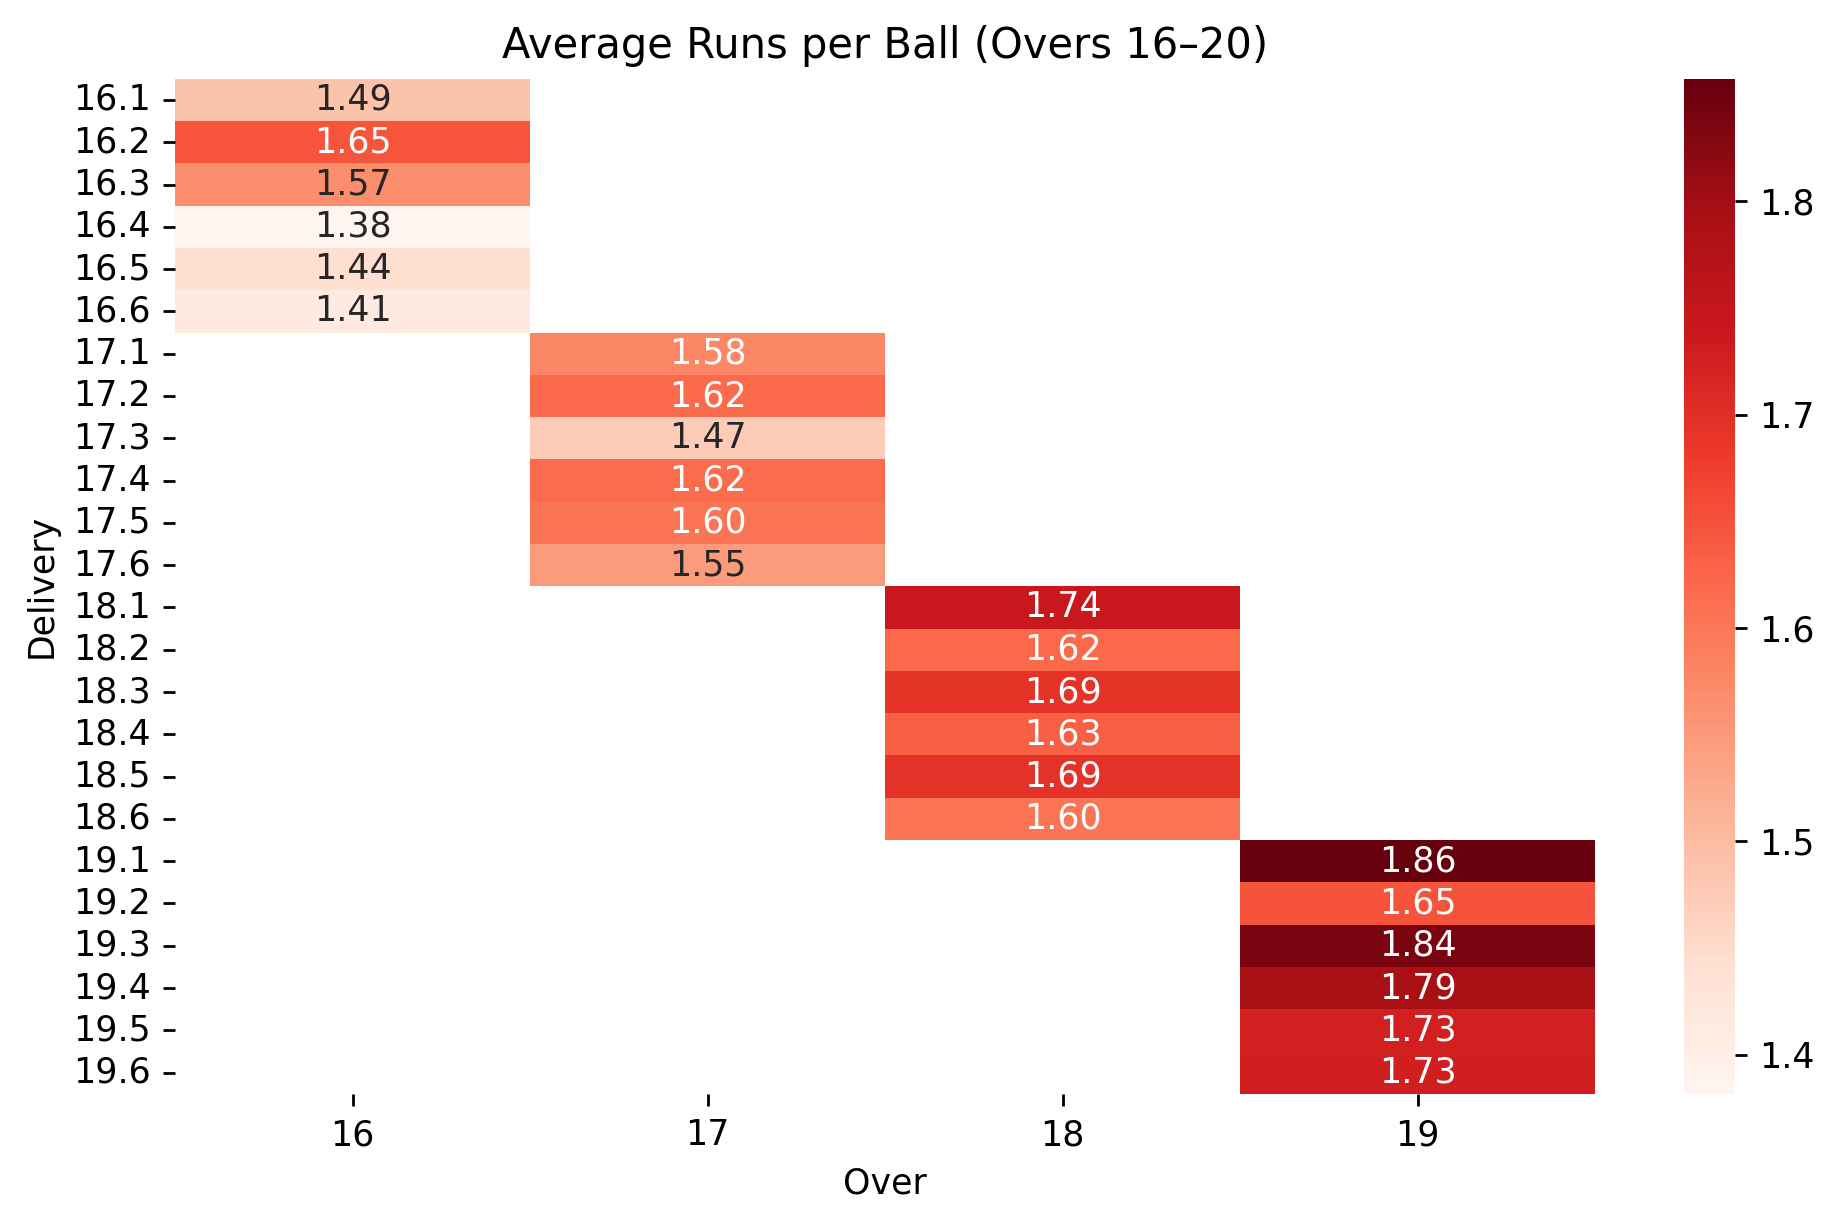

In [754]:
# Heatmap for average runs scored per ball (Identifies most expensive ball positions in death overs)
# Create a column for ball_number within over (1 to 6)
working_df['over_number'] = working_df['over'].astype(int)

# Pivot table for heatmap: mean runs per ball
heatmap_data = working_df.pivot_table(values = 'runs_of_bat', index = 'over', columns = 'over_number', aggfunc = 'mean')

plt.figure(figsize=(8, 5), dpi = 250)
sns.heatmap(heatmap_data, annot = True, cmap = 'Reds', fmt = ".2f")
plt.title('Average Runs per Ball (Overs 16–20)')
plt.xlabel('Over')
plt.ylabel('Delivery')
plt.tight_layout()
plt.show()

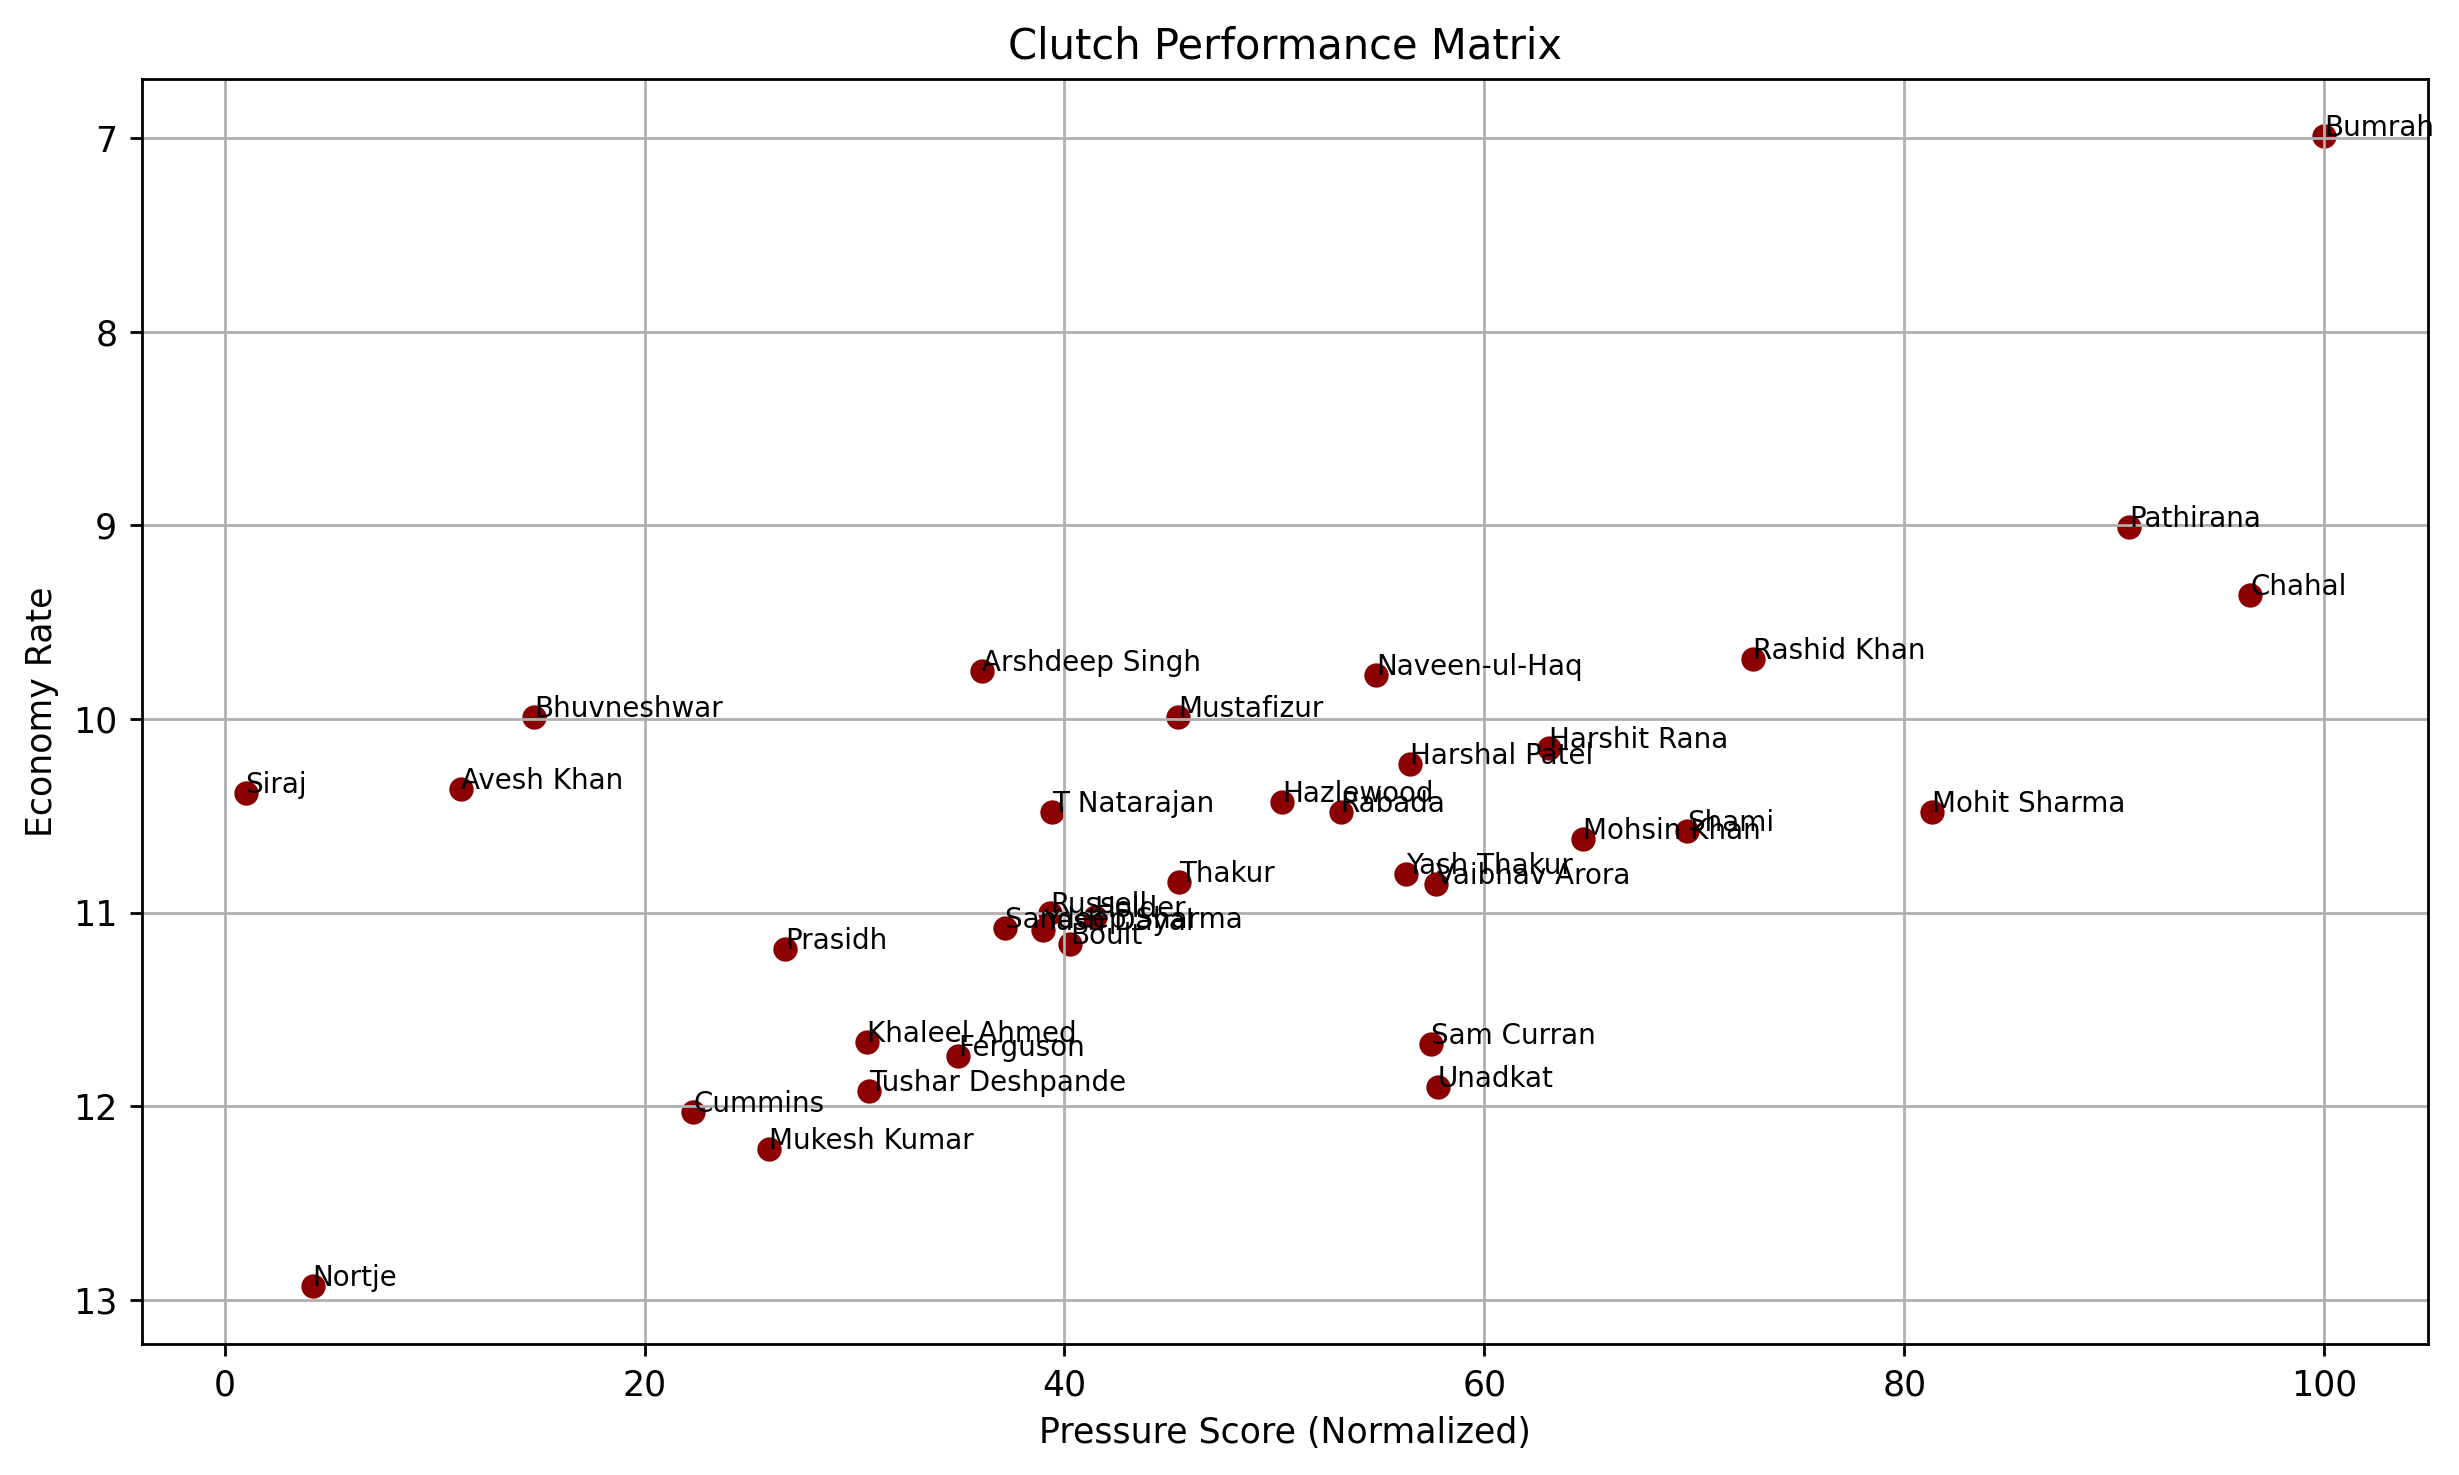

In [755]:
# Clutch Performance Matrix: Normalised Pressure Score vs Economy Rate
plt.figure(figsize = (10,6), dpi = 250)
plt.scatter(
    contextual_metrics['normalized_pressure'],
    contextual_metrics['economy_rate'],
    color = 'darkred'
)
plt.xlabel('Pressure Score (Normalized)')
plt.ylabel('Economy Rate')
plt.title('Clutch Performance Matrix')
for i, bowler in contextual_metrics.iterrows():
    plt.annotate(bowler['bowler'], (bowler['normalized_pressure'], bowler['economy_rate']), fontsize=8)
plt.gca().invert_yaxis()  # Lower economy is better
plt.grid(True)
plt.tight_layout()
plt.show()

In [756]:
# Interactive treemap to show the distribution of wicket types
wicket_counts = working_df['wicket_type'].value_counts().reset_index()
wicket_counts.columns = ['wicket_type', 'count']

fig = px.treemap(
    wicket_counts,
    path = ['wicket_type'],
    values = 'count',
    color = 'count',
    color_continuous_scale = 'Portland',
    title = 'Distribution of Wicket Types in Death Overs'
)
fig.update_traces(textinfo='label+value+percent entry')
fig.show()

In [757]:
top_bowlers = contextual_metrics['bowler'].tolist()
filtered_df = working_df[working_df['bowler'].isin(top_bowlers)]

avg_pressure_by_over = (
    filtered_df.groupby(['bowler', 'over_number'])['normalized_pressure'].mean().reset_index()
)

fig = px.line(
    avg_pressure_by_over,
    x = 'over_number',
    y = 'normalized_pressure',
    color = 'bowler',
    title = 'Average Pressure Score by Over (16-20)',
    line_shape = 'spline',
    markers = True
)
fig.update_layout(
    xaxis_title = 'Over',
    yaxis_title = 'Average Pressure Score',
    template = 'plotly_white'
)

fig.show()